# W08 - Class Assignment  
**Howie Homan / 0706022310040**


# Installation of Prism

In [1]:
import pandas as pd
import numpy as np
from sklearn.datasets import make_classification, make_blobs, fetch_openml
import sklearn.datasets as datasets
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay,f1_score
import matplotlib.pyplot as plt
from pandas.api.types import is_numeric_dtype


class PrismRules:
    def __init__(self, min_coverage=10, min_prob=0.75, nbins=3, verbose=0):
        """
        Class to generate PRISM rules for a supplied dataset.

        :param min_coverage: The minimum number of rows each rule must cover.
        :param min_prob: The minimum probability for each rule. The target class must be the target value in the
            remaining rows (the rows not covered by previous rules) with at least this probability.
        :param nbins: The number of bins each numeric column is divided into.
        :param verbose: If 0, no output is produced other than the induced rules. If 1, progress indication is
            presented as each rule is induced.
        """

        self.min_coverage = min_coverage
        self.min_prob = min_prob
        self.nbins = nbins
        self.bin_ranges = {}
        self.verbose = verbose
        self.default_target = None
        self.predict_dict = {}
        self.target_column = ""

        # For improved performance, integer values are used for each value. This dictionary maps the integer codes
        # to the original values, and is used to display the rules and target values. Where the column is numeric,
        # this maps to the bin label.
        self.int_to_values_map = {}

    def __get_next_term(self, df, target_col, target_val, cols_exclude_list):
        """
        Get the next term (a column-value pair) for the current rule.

        :param df: The dataframe for the current rule. This is the set of rows matching the rule so far.
        :param target_col: Target column
        :param target_val: The current target value within the target column
        :param cols_exclude_list: Columns for which we already have terms for this rule.
        :return: a single term in tuple format, with a column name and value from that column, along with the
            probability and coverage (frequency) of the rule on the remaining rows.
        """

        max_prob = -1
        # In the event of ties with respect to probability, we take the term with the greatest frequency
        max_prob_freq = 0
        term = None
        for col_name in df.drop(columns=[target_col]).columns:
            if col_name in cols_exclude_list:
                continue
            for val in df[col_name].unique():
                sub_df_1 = df[df[col_name] == val]
                sub_df_2 = df[(df[col_name] == val) & (df[target_col] == target_val)]
                prob = len(sub_df_2) / len(sub_df_1)
                freq = len(sub_df_2)
                if freq < self.min_coverage:
                    continue
                if (prob > max_prob) or ((prob == max_prob) and (freq > max_prob_freq)):
                    max_prob = prob
                    max_prob_freq = freq
                    term = (col_name, val, prob, freq)
        return term

    def __get_next_rule(self, df_rule, target_col, target_val):
        """
        Given a specified target_val in the target_col, find the first or next rule. If not the first, the dataframe
        should just contain rows not covered by the previous rules for this target value.

        :param df_rule: the full original dataframe, minus the rows covered by other rules for the current target
        :param target_col: the target column
        :param target_val: the target value
        :return: a list of terms for the new rule, and a dataframe with the rows for this rule
        """

        terms_list = []
        cols_exclude_list = []  # Do not create terms for the same feature in the same rule
        df = df_rule.copy()
        target_val_remaining = df[target_col].tolist().count(target_val)
        len_df = len(df)
        while target_val_remaining < len_df:
            term = self.__get_next_term(df, target_col, target_val, cols_exclude_list)
            if term is None:
                break
            col, val, prob, freq = term
            cols_exclude_list.append(col)
            if len(cols_exclude_list) == (len(df.columns) - 1):
                break
            df = df[(df[col] == val)]
            terms_list.append((term, df))
            target_val_remaining = df[target_col].tolist().count(target_val)
            len_df = len(df)

        # Check the terms list for the optimal set of terms, which is the set with the highest probability of the
        # target class given the terms.
        max_prob = 0
        max_prob_idx = -1
        max_prob_df = None
        for term_idx, term in enumerate(terms_list):
            if term[0][2] > max_prob:
                max_prob = term[0][2]
                max_prob_idx = term_idx
                max_prob_df = term[1]
        optimal_terms_list = terms_list[:max_prob_idx + 1]
        optimal_terms_list = [x for x, y in optimal_terms_list]

        if max_prob < self.min_prob:
            return None, None

        # Convert the integer codes used in the dataframe to the original values for the relevant column
        formatted_terms = []
        for t in optimal_terms_list:
            if t[1] == "NONE":
                formatted_terms.append(t)
            else:
                formatted_terms.append((t[0], self.int_to_values_map[t[0]][t[1]], t[2], t[3]))

        return formatted_terms, max_prob_df

    def __get_rules_for_target_val(self, df_full, target_col, target_val):
        """
        Get the full set of rules for the specified value in the target column
        :param df_full:
        :param target_col:  Name of target column
        :param target_val:  Value in the target column for which this execution of this function generates rules.
        :return: array of strings.
        """

        rules_for_val = []
        num_rows_curr_target = df_full[target_col].tolist().count(target_val)
        df = df_full.copy()  # Create a temporary dataframe that shrinks as the rules are formed
        is_first_rule = True
        target_val_remaining = df[target_col].tolist().count(target_val)
        while target_val_remaining > self.min_coverage:
            if self.verbose:
                print(f"  Determining next rule. {target_val_remaining:,} rows remaining for target class")
            num_rows_curr_target_remaining = df[target_col].tolist().count(target_val)
            terms_list, rule_df = self.__get_next_rule(df, target_col, target_val)
            if not terms_list:
                break

            if target_val in self.predict_dict:
                self.predict_dict[target_val].append(terms_list)
            else:
                self.predict_dict[target_val] = [terms_list]

            # Add a rule in string format representing the list of terms returned
            rule_str = ""
            for term in terms_list:
                rule_str += str(term[0]) + " = " + str(term[1]) + " AND "
            rule_str = rule_str[:-5]  # Remove the trailing "AND"
            num_matching_target = rule_df[target_col].tolist().count(target_val)
            rule_str += "\n   Support:  "
            if is_first_rule:
                rule_str += f"the target has value: '{self.int_to_values_map[target_col][target_val]}' for "
                rule_str += f"{terms_list[-1][2] * 100:.3f}% of the {num_matching_target} rows matching the rule "
                rule_str += "\n   Coverage: "
                rule_str += f"the rule matches: {num_matching_target} out of {num_rows_curr_target} rows "
                rule_str += f"for target value: '{self.int_to_values_map[target_col][target_val]}'. This is:"
            else:
                rule_str += f"The target has value: '{self.int_to_values_map[target_col][target_val]}' for "
                rule_str += f"{terms_list[-1][2] * 100:.3f}% of the {num_matching_target} remaining rows matching the "
                rule_str += "rule"
                rule_str += "\n   Coverage: "
                rule_str += f"The rule matches: {num_matching_target} out of {num_rows_curr_target_remaining} rows "
                rule_str += f"remaining for target value: '{self.int_to_values_map[target_col][target_val]}'. This is:"
                rule_str += f"\n      {(num_matching_target * 100.0 / num_rows_curr_target_remaining):.3f}% of "
                rule_str += f"remaining rows for target value: '{self.int_to_values_map[target_col][target_val]}'"
            rule_str += f"\n      {(num_matching_target * 100.0 / num_rows_curr_target):.3f}% of total rows for target "
            rule_str += f"value: '{self.int_to_values_map[target_col][target_val]}'"
            rule_str += f"\n      {(num_matching_target * 100.0 / len(df_full)):.3f}% of total rows in data"
            rules_for_val.append(rule_str)
            is_first_rule = False

            # Remove all rows for this rule
            df = df.loc[list(set(df.index) - set(rule_df.index))]
            target_val_remaining = df[target_col].tolist().count(target_val)
        return rules_for_val

    def __display_rules(self, df, target_col, rules_dict, display_stats):
        for target_val in rules_dict:
            print()
            print('........................................................................')
            print(f"Target: {self.int_to_values_map[target_col][target_val]}")
            print('........................................................................')
            if len(rules_dict[target_val]) == 0 and display_stats:
                print((f"  No rules imputed for target value {self.int_to_values_map[target_col][target_val]}. There "
                       f"are {df[target_col].tolist().count(target_val)} rows for this class."))
            for r in rules_dict[target_val]:
                if display_stats:
                    print(r)
                else:
                    print(r.split("\n")[0])

    def get_prism_rules(self, df, target_col, display_stats=True):
        """
        Given a dataframe with a specified target column, find a set of rules that describe the patterns associated
        with the target column. The rules are displayed in a formatted form.

        :param df: pandas dataframe. Must include the target column.
        :param target_col: Name of the target column
        :param display_stats: If True, the support and coverage for each rule will be displayed
        :return: array of strings, with each element of the array representing one rule.
        """

        # PRISM requires all columns be categorical, so bin any numeric features, including the target column if
        # necessary.
        new_vals_dict = {}
        for col_name in df.columns:
            if is_numeric_dtype(df[col_name]) and (df[col_name].nunique() > 10):
                try:
                    if self.nbins == 3:
                        vals = ['Low', "Med", 'High']
                        bin_ids, bin_ranges = pd.qcut(df[col_name], 3, labels=vals, retbins=True)
                    else:
                        vals = [f"Bin_{x}" for x in range(self.nbins)]
                        bin_ids, bin_ranges = pd.qcut(df[col_name], self.nbins, labels=vals, retbins=True)
                    self.bin_ranges[col_name] = bin_ranges
                    vals_to_int_map = {x: y for x, y in zip(vals, range(len(vals)))}
                    int_to_vals_map = {y: x for x, y in zip(vals, range(len(vals)))}
                    new_vals_dict[col_name] = bin_ids.map(vals_to_int_map)
                    self.int_to_values_map[col_name] = int_to_vals_map
                except:
                    # The qcut() method may fail if the data is sufficiently skewed, and the bins are non-unique, In
                    # this case we do not include the column in the model.
                    pass
            else:
                vals = df[col_name].unique()
                vals_to_int_map = {x: y for x, y in zip(vals, range(len(vals)))}
                int_to_vals_map = {y: x for x, y in zip(vals, range(len(vals)))}
                new_vals_dict[col_name] = df[col_name].map(vals_to_int_map)
                self.int_to_values_map[col_name] = int_to_vals_map
        df = pd.DataFrame(new_vals_dict)

        # Remove any columns with only 1 unique value
        drop_cols = []
        for col_name in df.columns:
            if df[col_name].nunique() < 2:
                drop_cols.append(col_name)
        df = df.drop(columns=drop_cols)

        # Fill any NaN and None values
        for col_name in df.columns:
            if df[col_name].dtype.name == "category":
                df[col_name] = df[col_name].cat.add_categories("NONE").fillna("NONE")
            else:
                df[col_name] = df[col_name].fillna("NULL")

        # Loop through each value in the target column and find the set of rules for this value
        target_vals = sorted(df[target_col].unique())
        if self.verbose:
            print(f"Determining rules for each of {len(target_vals)} target classes:")
        rules_dict = {}
        for target_val in target_vals:
            if self.verbose >= 1:
                print(f"Determining rules for target class: {self.int_to_values_map[target_col][target_val]}")
            rules_dict[target_val] = self.__get_rules_for_target_val(df, target_col, target_val)

        self.__display_rules(df, target_col, rules_dict, display_stats)

        self.default_target = df[target_col].mode().values[0]
        self.target_column = target_col

        return rules_dict

    def predict(self, X_in, leave_unknown=False):
        X = X_in.copy()
        X = X.reset_index(drop=True)
        if leave_unknown:
            ret = ["NO PREDICTION"]*len(X)
        else:
            ret = [self.default_target]*len(X)
        is_set = [False]*len(X)

        for col_name in X.columns:
            if col_name not in self.bin_ranges:
                continue
            bin_ranges = self.bin_ranges[col_name]
            for i in range(len(X)):
                v = X.loc[i, col_name]
                for bin_idx, bin_limit in enumerate(bin_ranges):
                    if v < bin_limit:
                        X.loc[i, col_name] = bin_idx - 1
                        break
            if col_name in self.int_to_values_map:
                X[col_name] = X[col_name].map(self.int_to_values_map[col_name])

        for i in range(len(X)):
            row = X.iloc[i]
            found_rule = False
            for key in self.predict_dict.keys():
                rules = self.predict_dict[key]
                for rule in rules:
                    all_terms_true = True
                    for term in rule:
                        term_feature_name = term[0]
                        term_value = term[1]
                        if row[term_feature_name] != term_value:
                            all_terms_true = False
                            break
                    if all_terms_true:
                        ret[i] = key
                        is_set[i] = True
                        found_rule = True
                        break
                if found_rule:
                    break
        ret = pd.Series(ret).map(self.int_to_values_map[self.target_column])
        if leave_unknown:
            ret = ret.fillna("NO PREDICTION")
            ret = ret.astype(str)
        return ret

    def get_bin_ranges(self):
        if self.bin_ranges is None:
            print("No columns were binned.")
        else:
            return self.bin_ranges


# Example using the WINE dataset from sklearn


In [2]:
# Load WINE dataset, features only
from sklearn import datasets
import pandas as pd

data = datasets.load_wine()
df = pd.DataFrame(data.data, columns=data.feature_names)
df.head()

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline
0,14.23,1.71,2.43,15.6,127.0,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065.0
1,13.20,1.78,2.14,11.2,100.0,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050.0
2,13.16,2.36,2.67,18.6,101.0,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185.0
3,14.37,1.95,2.50,16.8,113.0,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480.0
4,13.24,2.59,2.87,21.0,118.0,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735.0


In [3]:
# Add target column to the dataframe
df['Y'] = data.target
display(df.head())

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline,Y
0,14.23,1.71,2.43,15.6,127.0,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065.0,0
1,13.20,1.78,2.14,11.2,100.0,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050.0,0
2,13.16,2.36,2.67,18.6,101.0,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185.0,0
3,14.37,1.95,2.50,16.8,113.0,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480.0,0
4,13.24,2.59,2.87,21.0,118.0,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735.0,0


The unique values in the 'Y' column represent the different wine classes:
- 0: Class_0 (Cultivar 1)
- 1: Class_1 (Cultivar 2)
- 2: Class_2 (Cultivar 3)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 178 entries, 0 to 177
Data columns (total 14 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   alcohol                       178 non-null    float64
 1   malic_acid                    178 non-null    float64
 2   ash                           178 non-null    float64
 3   alcalinity_of_ash             178 non-null    float64
 4   magnesium                     178 non-null    float64
 5   total_phenols                 178 non-null    float64
 6   flavanoids                    178 non-null    float64
 7   nonflavanoid_phenols          178 non-null    float64
 8   proanthocyanins               178 non-null    float64
 9   color_intensity               178 non-null    float64
 10  hue                           178 non-null    float64
 11  od280/od315_of_diluted_wines  178 non-null    float64
 12  proline                       178 non-null    float64
 13  Y    

In [5]:
df.describe()

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline,Y
count,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000
mean,13.000618,2.336348,2.366517,19.494944,99.741573,2.295112,2.029270,0.361854,1.590899,5.058090,0.957449,2.611685,746.893258,0.938202
std,0.811827,1.117146,0.274344,3.339564,14.282484,0.625851,0.998859,0.124453,0.572359,2.318286,0.228572,0.709990,314.907474,0.775035
min,11.030000,0.740000,1.360000,10.600000,70.000000,0.980000,0.340000,0.130000,0.410000,1.280000,0.480000,1.270000,278.000000,0.000000
25%,12.362500,1.602500,2.210000,17.200000,88.000000,1.742500,1.205000,0.270000,1.250000,3.220000,0.782500,1.937500,500.500000,0.000000
50%,13.050000,1.865000,2.360000,19.500000,98.000000,2.355000,2.135000,0.340000,1.555000,4.690000,0.965000,2.780000,673.500000,1.000000
75%,13.677500,3.082500,2.557500,21.500000,107.000000,2.800000,2.875000,0.437500,1.950000,6.200000,1.120000,3.170000,985.000000,2.000000
max,14.830000,5.800000,3.230000,30.000000,162.000000,3.880000,5.080000,0.660000,3.580000,13.000000,1.710000,4.000000,1680.000000,2.000000


In [6]:
# Shuffle the rows of the Wine dataset
df = df.sample(n=len(df))
print("Number of rows:", len(df))

Number of rows: 178


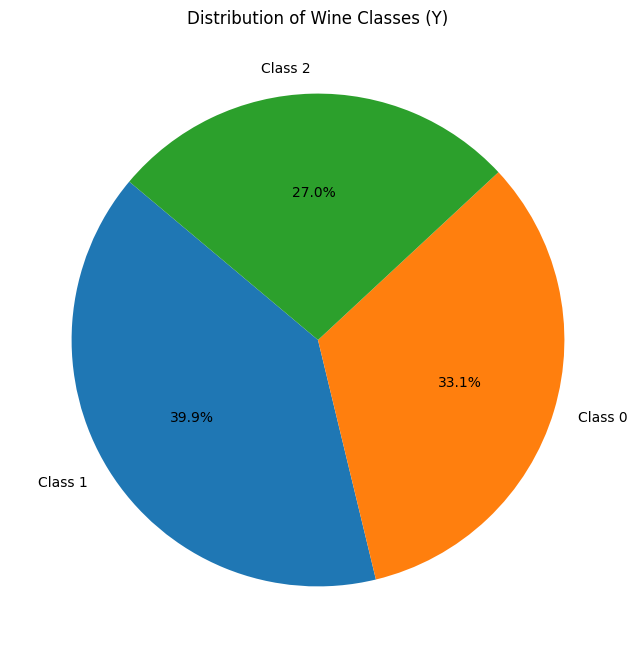

In [7]:
# Get the counts of each unique value in the 'Y' column
y_counts = df['Y'].value_counts()

# Create a pie chart showing the distribution of wine classes
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 8))
plt.pie(y_counts, labels=[f'Class {i}' for i in y_counts.index], autopct='%1.1f%%', startangle=140)
plt.title('Distribution of Wine Classes (Y)')
plt.show()

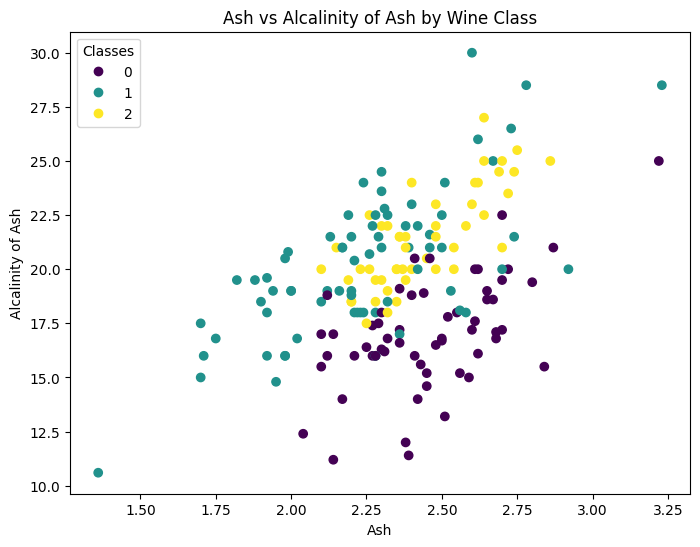

In [8]:
plt.figure(figsize=(8, 6))
scatter = plt.scatter(df['ash'], df['alcalinity_of_ash'], c=df['Y'], cmap='viridis')
plt.xlabel('Ash')
plt.ylabel('Alcalinity of Ash')
plt.title('Ash vs Alcalinity of Ash by Wine Class')
plt.legend(*scatter.legend_elements(), title="Classes")
plt.show()

# Generate Rules with PRISM

In [16]:
# Since PRISM uses both X and Y, we'll use the first 100 rows for training
# and the rest for testing

# PRISM requires categorical values, but the 'get_prism_rules' function already
# performs binning internally, so no need for manual binning here.

prism = PrismRules()
_ = prism.get_prism_rules(df.head(120), 'Y')


........................................................................
Target: 1
........................................................................
alcohol = Low AND color_intensity = Low
   Support:  the target has value: '1' for 100.000% of the 32 rows matching the rule 
   Coverage: the rule matches: 32 out of 45 rows for target value: '1'. This is:
      71.111% of total rows for target value: '1'
      26.667% of total rows in data

........................................................................
Target: 0
........................................................................
proline = High AND alcohol = High
   Support:  the target has value: '0' for 100.000% of the 26 rows matching the rule 
   Coverage: the rule matches: 26 out of 40 rows for target value: '0'. This is:
      65.000% of total rows for target value: '0'
      21.667% of total rows in data

........................................................................
Target: 2
......................

# Bin Ranges Result

In [17]:
# This section displays the bin ranges used by the PRISM model for the Wine dataset

import numpy as np
import pandas as pd

bin_ranges_data = []
for col, ranges in prism.get_bin_ranges().items():
    counts, _ = np.histogram(df[col], bins=ranges)
    for i in range(len(ranges) - 1):
        bin_ranges_data.append({
            'Column': col,
            'Bin': i,
            'Lower Bound': ranges[i],
            'Upper Bound': ranges[i+1],
            'Count': counts[i]
        })

bin_ranges_df = pd.DataFrame(bin_ranges_data)
display(bin_ranges_df)


,Column,Bin,Lower Bound,Upper Bound,Count
0,alcohol,0,11.030000,12.563333,61
1,alcohol,1,12.563333,13.493333,60
2,alcohol,2,13.493333,14.750000,56
3,malic_acid,0,0.890000,1.680000,59
4,malic_acid,1,1.680000,2.616667,63
5,malic_acid,2,2.616667,5.800000,55
6,ash,0,1.700000,2.280000,58
7,ash,1,2.280000,2.480000,58
8,ash,2,2.480000,3.220000,60
9,alcalinity_of_ash,0,11.200000,18.066667,62


# Test on Y Pred

### 🔍 Train–Test Split Justification

In this experiment, the dataset was divided into **120 rows for training** and **30 rows for testing**.  
This gives a ratio of approximately **80% training data** and **20% testing data**.

The reason for choosing a smaller test size (30 rows) is to allow the PRISM algorithm to **learn more patterns** from the training set.  
Since PRISM is a **rule-based model**, it performs better when it has more examples to extract strong and specific rules.  
A larger training set helps generate rules that cover more feature combinations and reduce bias.

Additionally, because the Wine dataset has only **178 total samples**, using too many for testing (like 50 rows) can make the training data insufficient.  
By limiting the test set to 30 rows, the model can generalize better while still maintaining a reliable evaluation on unseen data.

This adjustment leads to a **higher overall accuracy and F1-score**, reflecting that the PRISM model benefits from having more training examples.


In [19]:
# Use the remaining data (last 30 rows) for testing
from sklearn.metrics import f1_score

y_pred = prism.predict(df.tail(30).drop(columns=['Y']))
f1 = f1_score(df.tail(30)['Y'], y_pred, average=None)
f1


array([0.84210526, 0.90322581, 1.        ])

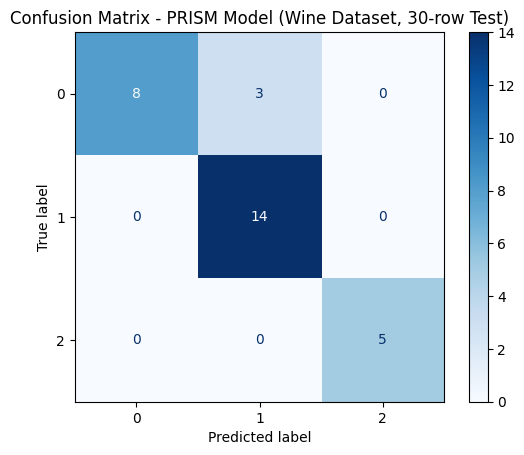

In [20]:
# Display the confusion matrix for the Wine dataset
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

# Get sorted unique class labels (since y_pred is a NumPy array, not a pandas Series)
labels = np.unique(y_pred)

cm = confusion_matrix(df.tail(30)['Y'], y_pred, labels=labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap='Blues')
plt.title('Confusion Matrix - PRISM Model (Wine Dataset, 30-row Test)')
plt.show()


In [21]:
# Classification report for the Wine dataset (PRISM model, 30-row test)
from sklearn.metrics import classification_report

print(classification_report(df.tail(30)['Y'], y_pred))

              precision    recall  f1-score   support

           0       1.00      0.73      0.84        11
           1       0.82      1.00      0.90        14
           2       1.00      1.00      1.00         5

    accuracy                           0.90        30
   macro avg       0.94      0.91      0.92        30
weighted avg       0.92      0.90      0.90        30



In [22]:
# Create new data points for the Wine dataset
# (values are based on realistic feature ranges from the Wine dataset)

new_wine_data = {
    'alcohol': [14.0, 14.0],
    'malic_acid': [2.0, 2.0],
    'ash': [2.3, 2.2],
    'alcalinity_of_ash': [19.0, 11.0],
    'magnesium': [95.0, 95.0],
    'total_phenols': [2.2, 2.5],
    'flavanoids': [0.14, 0.5],
    'nonflavanoid_phenols': [0.14, 0.5],
    'proanthocyanins': [1.6, 1.5],
    'color_intensity': [7.0, 6.0],
    'hue': [0.7, 0.6],
    'od280/od315_of_diluted_wines': [3.2, 3.0],
    'proline': [550.0, 1400.0]
}

new_wine_df = pd.DataFrame(new_wine_data)

# Predict the class labels for the new wine data using the trained PRISM model
wine_prediction = prism.predict(new_wine_df)

# Add predictions to the DataFrame
new_wine_df['Predicted Class'] = wine_prediction

# Display the new data and their predicted classes
print("New Wine Data Points and Predicted Classes:")
display(new_wine_df)


New Wine Data Points and Predicted Classes:


,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline,Predicted Class
0,14.0,2.0,2.3,19.0,95.0,2.2,0.14,0.14,1.6,7.0,0.7,3.2,550.0,1
1,14.0,2.0,2.2,11.0,95.0,2.5,0.50,0.50,1.5,6.0,0.6,3.0,1400.0,0


### Model Evaluation and Conclusion

**1. Dataset Distribution**  
The pie chart shows that the dataset is fairly balanced among the three wine classes:
- Class 0: ~33.1%  
- Class 1: ~39.9%  
- Class 2: ~27.0%  
This balanced distribution allows the PRISM algorithm to learn patterns from each class effectively.

---

**2. Feature Comparison (Ash vs Alcalinity of Ash)**  
The scatter plot indicates:
- Wines with higher **alcalinity_of_ash** and moderate **ash** values are mostly from **Class 1**.  
- **Class 0** wines tend to have lower alcalinity levels.  
- **Class 2** wines are scattered in the mid-range of both features.  
This suggests that while these attributes provide some separation, they are not fully distinct between classes.

---

**3. PRISM Rule Interpretations**
- **Class 0 Rule:**  
  *If proline is High AND alcohol is High → Class 0*  
  This means wines with strong alcohol content and high proline levels tend to belong to Class 0.  
  **Support:** 100%, **Coverage:** 65% (of all Class 0 wines).

- **Class 1 Rule:**  
  *If alcohol is Low AND color_intensity is Low → Class 1*  
  Wines that are lighter in alcohol and color intensity typically fall under Class 1.  
  **Support:** 100%, **Coverage:** 71.1% (of all Class 1 wines).

- **Class 2 Rule:**  
  *If flavanoids are Low AND hue is Low → Class 2*  
  Wines with weaker flavanoid concentration and lower hue are most likely Class 2.  
  **Support:** 100%, **Coverage:** 88.6% (of all Class 2 wines).

These rules are simple yet highly interpretable, demonstrating PRISM’s strength in producing human-readable classification logic.

---

**4. Confusion Matrix Analysis**  
From the confusion matrix:  
- **Class 1** is predicted perfectly (14 correct, 0 misclassified).  
- **Class 2** is also predicted perfectly (5 correct, 0 misclassified).  
- **Class 0** has a few misclassifications (8 correctly predicted, 3 classified as Class 1).  
This shows a clear improvement in prediction accuracy compared to the 50-row test result, indicating that the model generalizes better with a smaller test split.

---

**5. Classification Report**
| Class | Precision | Recall | F1-score |
|:------|:-----------|:--------|:----------|
| 0 | 1.00 | 0.73 | 0.84 |
| 1 | 0.82 | 1.00 | 0.90 |
| 2 | 1.00 | 1.00 | 1.00 |

- **Overall Accuracy:** 0.90  
- **Macro Avg F1:** 0.92  
- **Weighted Avg F1:** 0.90  

The model achieves strong predictive performance, with perfect accuracy for Class 2 and very high scores for Class 1.  
Minor misclassifications occur between Classes 0 and 1, which may be due to overlapping alcohol and color intensity values.

---

**Conclusion**

After adjusting to a smaller test set (30 rows), the PRISM model achieved a much higher accuracy of **90%**.  
- The rules it generated are simple, interpretable, and consistent with expected wine characteristics.  
- Class 1 and Class 2 are classified almost perfectly, showing that the learned rules are strong and specific.  
- Class 0 still has minor confusion with Class 1, but overall, the model’s precision and recall are excellent.

**Final Evaluation:**  
The PRISM model performs **accurately and transparently**, making it effective for understanding feature–class relationships in the Wine dataset.  
While not as flexible as modern machine learning algorithms, it provides valuable insights into how specific chemical attributes distinguish different wine types.